## Table of contents

   [Step 1: Answering the question](#Step-1:-Answering-the-question)
   
   [Step 2: Checking the data](#Step-2:-Checking-the-data)

Made by these examples:

http://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb

https://www.kaggle.com/anokas/outbrain-click-prediction/outbrain-eda/notebook

https://github.com/gabrielspmoreira/static_resources/blob/gh-pages/Kaggle-Outbrain-PageViews_EventsAnalytics.ipynb

## Step 1: Answering the question

>Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

Kagglers are challenged to predict which pieces of content its global base of users are likely to click on

>Did you define the metric for success before beginning?

[Evaluation](https://www.kaggle.com/c/outbrain-click-prediction/details/evaluation)
[Code](https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py#L34)

>Did you understand the context for the question and the scientific or business application?

Improving Outbrain’s recommendation algorithm will mean more users uncover stories that satisfy their individual tastes. Your task is to rank the recommendations in each group by decreasing predicted likelihood of being clicked.

>Did you record the experimental design?

[Dataset description](https://www.kaggle.com/c/outbrain-click-prediction/data)

>Did you consider whether the question could be answered with the available data?

At least [this solution](https://www.kaggle.com/clustifier/outbrain-click-prediction/btb-0-63523-evaluation/code) is better then benchmark (Submitting all candidate ad_ids in sorted order)

## Step 2: Checking the data

[[ go back to the top ]](#Table-of-contents)

The next step is to look at the data we're working with. Even curated data sets from the government can have errors in them, and it's vital that we spot these errors before investing too much time in our analysis.

Generally, we're looking to answer the following questions:

* Is there anything wrong with the data?
* Are there any quirks with the data?
* Do I need to fix or remove any of the data?

Let's start by reading the data into a pandas DataFrame.

In [26]:
import pandas as pd
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

sb_c = sb.color_palette()

### Page views

timestamp (ms since 1970-01-01 - 1465876799998)

platform (desktop = 1, mobile = 2, tablet =3)

geo_location (country>state>DMA)

traffic_source (internal = 1, search = 2, social = 3)

In [2]:
pvs = pd.read_csv('page_views_sample.csv') #page_views.csv is a the log of users visiting documents
pvs.head()

,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1
3,8205775c5387f9,120,44196592,1,IN>16,2
4,9cb0ccd8458371,120,65817371,1,US>CA>807,2


In [4]:
len(pvs), len(pvs['uuid'].unique()), len(pvs['document_id'].unique()), len(pvs['geo_location'].unique())

(9999999, 9202149, 59849, 2964)

In [5]:
len(pvs[pvs['platform'] == 1]), len(pvs[pvs['platform'] == 2]), len(pvs[pvs['platform'] == 3])

(4403345, 4678799, 917855)

In [6]:
len(pvs[pvs['traffic_source'] == 1]), len(pvs[pvs['traffic_source'] == 2]), len(pvs[pvs['traffic_source'] == 3])

(6668961, 1667170, 1663868)

All numeric columns are filled.
Most of views have unique uuid. 45% - desktop, 45% - mobile. 67% - internal traffic.

[Full dataset analysis using PySpark](https://github.com/gabrielspmoreira/static_resources/blob/gh-pages/Kaggle-Outbrain-PageViews_EventsAnalytics.ipynb):

* we can see that 65% of the users have only 1 page view, 77%, have at most 2 page views and 89% of the users have at most 5 page views.

[Explore user base by GEO](https://www.kaggle.com/andreyg/outbrain-click-prediction/explore-user-base-by-geo):

* As we can see more than 81% of all Users are from USA.
* Most in USA: California


### Events

In [13]:
#events.csv provides information on the display_id context. It covers both the train and test set.
events = pd.read_csv('events.csv', dtype={'display_id': int, 'document_id' : int, 'timestamp':int, 'platform':str, 'uuid':str, 'geo_location':str})
events.head()


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [13]:
len(events), len(events['display_id'].unique()), len(events['uuid'].unique()), len(events['document_id'].unique())

(23120126, 23120126, 19794967, 894060)

In [15]:
print events['platform'].unique()

['3' '2' '1' '\\N']


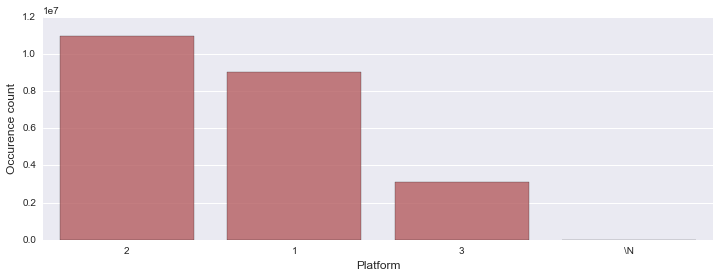

In [27]:
events.platform = events.platform.astype(str)
plat = events.platform.value_counts()

plt.figure(figsize=(12,4))
sb.barplot(plat.index, plat.values, alpha=0.8, color=sb_c[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

uuid
ef7761dd22277c    38
45d23867dbe3b3    38
c0bd502c7a479f    42
2759b057797f02    46
b88553e3a2aa29    49
Name: uuid, dtype: int64
Users that appear less than 2 times: 88.42%
Users that appear less than 5 times: 99.51%
Users that appear less than 10 times: 99.96%


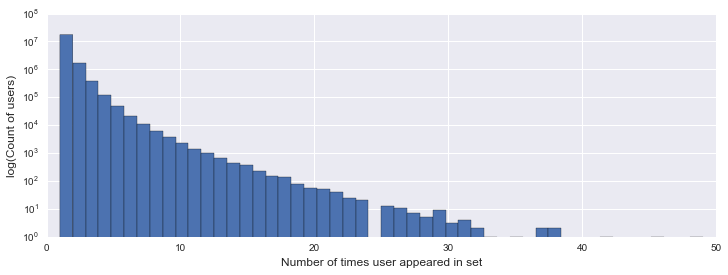

In [28]:
uuid_counts = events.groupby('uuid')['uuid'].count().sort_values()

print(uuid_counts.tail())

for i in [2, 5, 10]:
    print('Users that appear less than {} times: {}%'.format(i, round((uuid_counts < i).mean() * 100, 2)))
    
plt.figure(figsize=(12, 4))
plt.hist(uuid_counts.values, bins=50, log=True)
plt.xlabel('Number of times user appeared in set', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.show()

[Full dataset analysis using PySpark](https://github.com/gabrielspmoreira/static_resources/blob/gh-pages/Kaggle-Outbrain-PageViews_EventsAnalytics.ipynb):

* We discovered that fields (uuid, document_id, platform, geo_location and day(timestamp)) can be used to effectivelly join both datasets. And events dataset can be considered to be a subset of page_views dataset, as almost all (99.76%) its rows can be matched in page_views.csv using these fields.
* We also discovered that 75% of users in events.csv have additional logged visits on page_views.csv, which hopefully might be used to model users preferences for personalized ads ranking

[Timestamp exploration](https://www.kaggle.com/joconnor/outbrain-click-prediction/date-exploration-and-train-test-split/comments)




### Promoted content

In [30]:
ads = pd.read_csv('promoted_content.csv') # promoted_content.csv provides details on the ads.
ads.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [32]:
len(ads), len(ads['ad_id'].unique()), len(ads['document_id'].unique()), len(ads['campaign_id'].unique()), len(ads['advertiser_id'].unique())

(559583, 559583, 185709, 34675, 4385)

### Documents

In [12]:
docs_meta = pd.read_csv('documents_meta.csv') # documents_meta.csv provides details on the documents.
docs_meta.head()

,document_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


In [14]:
len(docs_meta), len(docs_meta['document_id'].unique())

(2999334, 2999334)

In [35]:
docs_topics = pd.read_csv('documents_topics.csv') 
docs_topics.head()

,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


In [48]:
len(docs_topics), len(docs_topics['document_id'].unique()), len(docs_topics['topic_id'].unique())

(11325960, 2495423, 300)

In [38]:
docs_ent = pd.read_csv('documents_entities.csv') 
docs_ent.head()

,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193


In [46]:
len(docs_ent), len(docs_ent['document_id'].unique()), len(docs_ent['entity_id'].unique())

(5537552, 1791420, 1326009)

In [39]:
docs_cat = pd.read_csv('documents_categories.csv') 
docs_cat.head()

,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92
3,1524246,1608,0.07
4,1617787,1807,0.92


In [47]:
len(docs_cat), len(docs_cat['document_id'].unique()), len(docs_cat['category_id'].unique())

(5481475, 2828649, 97)

### Train data

In [51]:
train = pd.read_csv('clicks_train.csv', nrows = 100) 
train.head(10)

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
5,1,296965,0
6,2,125211,0
7,2,156535,0
8,2,169564,0
9,2,308455,1


### Test data

In [52]:
test = pd.read_csv('clicks_test.csv', nrows = 100) 
test.head(10)

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888
5,16874594,180797
6,16874595,8846
7,16874595,30609
8,16874595,143982
9,16874596,11430
